In [1]:
import pandas as pd

In [2]:
casp3   = '../casp3'
actives = pd.read_csv(f'{casp3}/actives_final.ism', header=None, delim_whitespace=True, usecols=[2])
decoys  = pd.read_csv(f'{casp3}/decoys_final.ism' , header=None, delim_whitespace=True, usecols=[1])

actives.columns=['id']
actives['kind']=0

decoys.columns=['id']
decoys['kind']=1

# Someone removed "ZIN" from "ZINC" at decoys_final.ism
decoys['id']='ZIN'+decoys['id']

In [3]:
d = {}

# Read Qvina Scores
d['qvina'] = pd.read_csv('qvina.csv.gz', compression='gzip')

# Read rescores
for SF in ['vina','smina','vinardo']:
    d[SF] = pd.read_csv('rescore_' + SF + '.csv.gz', compression='gzip')
    
# Read RF-ScoreVS_v2 rescore
d['RFScoreVS_v2'] = pd.read_csv('rescore_rfscore.csv.gz', compression='gzip')
d['RFScoreVS_v2'].columns=['pose','id','RFScoreVS_v2']
d['RFScoreVS_v2']['RFScoreVS_v2'] = -d['RFScoreVS_v2']['RFScoreVS_v2']

In [4]:
# Concatenate all into "data"
df   = pd.concat([actives, decoys])
data = pd.merge(df, d['qvina'], on='id')
for v in list(d.values())[1:]:
    data = pd.merge(data, v, on=['id','pose'])

In [5]:
data

,id,kind,pose,qvina,vina,smina,vinardo,RFScoreVS_v2
0,CHEMBL180669,0,1,-4.4,-4.38646,-5.29339,-6.40548,-6.321281
1,CHEMBL180669,0,2,-4.3,-3.82455,-4.80099,-5.38578,-6.048931
2,CHEMBL180669,0,3,-4.2,7.86672,-5.27078,-6.88374,-6.170112
3,CHEMBL180669,0,4,-3.6,-3.55853,-4.50132,-6.04625,-5.968666
4,CHEMBL180669,0,5,-2.2,-2.83825,-4.25298,-4.49868,-5.959378
...,...,...,...,...,...,...,...,...
101697,ZINC67402245,1,6,-4.8,-4.63371,-5.28064,-4.81779,-5.956450
101698,ZINC67402245,1,7,-4.6,-4.52925,-5.02807,-3.78149,-5.952462
101699,ZINC67402245,1,8,-4.5,-4.11110,-5.18475,-4.20107,-5.958158
101700,ZINC67402245,1,9,-4.5,-3.84293,-4.24558,-3.35078,-5.968451


In [6]:
total = len(data)

In [7]:
#from scipy import stats

In [8]:
#import statistics

In [9]:
#for SF in data.columns[3:]:
    # Remove outliers by the IQR method
    #Q1   = data[SF].quantile(0.25)
    #Q3   = data[SF].quantile(0.75)
    #IQR  = Q3 - Q1
    #data = data[~((data[SF] < (Q1 - 1.5 * IQR))|(data[SF] > (Q3 + 1.5 * IQR)))]
    
    # Or Remove outliers by the MAD method
    #M = statistics.median(data[SF])
    #MAD = stats.median_absolute_deviation(data[SF])
    #data = data[~((data[SF] < (M - 3 * MAD))|(data[SF] > (M + 3 * MAD)))]

In [10]:
data

,id,kind,pose,qvina,vina,smina,vinardo,RFScoreVS_v2
0,CHEMBL180669,0,1,-4.4,-4.38646,-5.29339,-6.40548,-6.321281
1,CHEMBL180669,0,2,-4.3,-3.82455,-4.80099,-5.38578,-6.048931
2,CHEMBL180669,0,3,-4.2,7.86672,-5.27078,-6.88374,-6.170112
3,CHEMBL180669,0,4,-3.6,-3.55853,-4.50132,-6.04625,-5.968666
4,CHEMBL180669,0,5,-2.2,-2.83825,-4.25298,-4.49868,-5.959378
...,...,...,...,...,...,...,...,...
101697,ZINC67402245,1,6,-4.8,-4.63371,-5.28064,-4.81779,-5.956450
101698,ZINC67402245,1,7,-4.6,-4.52925,-5.02807,-3.78149,-5.952462
101699,ZINC67402245,1,8,-4.5,-4.11110,-5.18475,-4.20107,-5.958158
101700,ZINC67402245,1,9,-4.5,-3.84293,-4.24558,-3.35078,-5.968451


In [11]:
print(f'{total - len(data)} removed outliers: {total} -> {len(data)}')

0 removed outliers: 101702 -> 101702


In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

[Scoring Function]: [AUC]
qvina: 0.573809
vina: 0.617383
smina: 0.614721
vinardo: 0.700648
RFScoreVS_v2: 0.782020


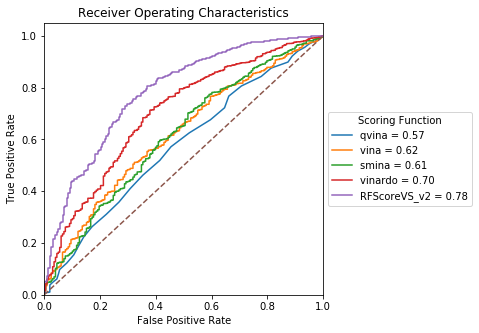

In [13]:
print('[Scoring Function]: [AUC]')
fig, ax = plt.subplots(figsize=(5,5))
for SF in d.keys():
    # 1st top pose according to each scoring function
    df = data.sort_values(SF).groupby('id').head(1)
    fpr, tpr, _ = roc_curve(df['kind'].to_numpy(), df[SF].to_numpy())
    roc_auc = auc(fpr, tpr)
    print(f'{SF}: {roc_auc:>.6f}')
    ax.plot(fpr, tpr, label=f'{SF} = {roc_auc:>.2f}')

# Plot a line
ax.plot([0,1], [0,1], linestyle='--')

# Some legends
ax.set(xlim=[0.0,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', ylabel='True Positive Rate', title='Receiver Operating Characteristics')
plt.legend(title='Scoring Function', loc='center left', bbox_to_anchor=(1.0, 0.5))